In [196]:
# reference: 
# https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
# https://github.com/yanneta/deep-learning-with-pytorch/blob/master/lesson9-muti-task-fish.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import cv2
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install albumentations

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [4]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 11996954624
free     : 11996954624
used     : 0


### **Notes**:

- Haven't take images without bboxes into account.

- Train / valid split.

- Resize bboxes in a better way.

- Why albumentation changes int to float.

In [46]:
from pathlib import Path

path = Path("../data")
image_folder = Path("../data/train")
resize_folder = Path("../data/resize_train")

## Read data

In [47]:
# read raw train data
train = pd.read_csv(path/"train.csv")
print(train.shape)
train.head()

(147793, 5)


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [48]:
# read clean wheat data
wheat = pd.read_csv(path/"wheat.csv")
print(wheat.shape)
wheat.head()

(147793, 5)


,image_id,xmin,ymin,xmax,ymax
0,b6ab77fd7.jpg,834.0,222.0,890.0,258.0
1,b6ab77fd7.jpg,226.0,548.0,356.0,606.0
2,b6ab77fd7.jpg,377.0,504.0,451.0,664.0
3,b6ab77fd7.jpg,834.0,95.0,943.0,202.0
4,b6ab77fd7.jpg,26.0,144.0,150.0,261.0


## Train / Valid split

- **usask_1** and **rres_1** as validation set.
- Number of images roughly 20%.

In [49]:
# carve out a validation set from 2 sources
valid_id = train.loc[train.source.isin(["usask_1", "rres_1"])].image_id.unique()
len(valid_id)

632

In [50]:
# number of training examples
train.image_id.nunique() - len(valid_id)

2741

In [51]:
valid_id = [Id+".jpg" for Id in valid_id]  # image_id of validation set

In [52]:
train_wheat = wheat.loc[~wheat.image_id.isin(valid_id)].reset_index(drop=True)
valid_wheat = wheat.loc[wheat.image_id.isin(valid_id)].reset_index(drop=True)
print("train:", train_wheat.shape, "valid:", valid_wheat.shape)

train: (121750, 5) valid: (26043, 5)


In [53]:
train_wheat.head()

,image_id,xmin,ymin,xmax,ymax
0,44c60402e.jpg,830.0,21.0,896.0,78.0
1,44c60402e.jpg,752.0,0.0,804.0,49.0
2,44c60402e.jpg,321.0,0.0,467.0,32.0
3,44c60402e.jpg,363.0,32.0,471.0,97.0
4,44c60402e.jpg,555.0,63.0,612.0,109.0


In [54]:
# train_wheat[["xmin", "ymin", "xmax", "ymax"]] = train_wheat[["xmin", "ymin", "xmax", "ymax"]] \
#                                                             .apply(lambda x: np.array(x * 224 / 1024, dtype=np.int32))
# valid_wheat[["xmin", "ymin", "xmax", "ymax"]] = valid_wheat[["xmin", "ymin", "xmax", "ymax"]] \
#                                                             .apply(lambda x: np.array(x * 224 / 1024, dtype=np.int32))

## Original images and bboxes

In [64]:
def read_image(path):
    """
    Read image from path, convert to RGB channel.
    """
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert to B G R channels

def get_im_bb(path, df):
    """
    Get single image and bbox based on path and df.
    """
    im = read_image(path)
    image_id = path.parts[-1]
    bboxes = df.loc[df.image_id == image_id, ["xmin", "ymin", "xmax", "ymax"]].values
    return im, bboxes

In [65]:
# example
p = image_folder/"44c60402e.jpg"
im, bboxes = get_im_bb(p, train_wheat)
im.shape, len(bboxes)

((1024, 1024, 3), 60)

In [66]:
def create_corner_rect(bb, color='red'):
    """
    Create a red bbox for plotting.
    """
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=2)

def show_corner_bb(im, bboxes):
    """
    Plot image with bbox.
    """
    plt.imshow(im)
    for bb in bboxes:
        plt.gca().add_patch(create_corner_rect(bb))

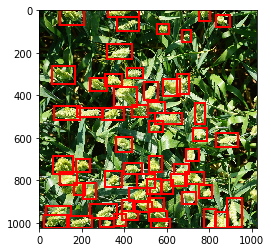

In [67]:
show_corner_bb(im, bboxes)

## Bboxes to pixels

In [68]:
def make_bb_px(y, x):
    """
    Makes an image of size x retangular bounding box.
    Represent bbox using image.
    """
    r,c,*_ = x.shape
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[1]:y[3]+1, y[0]:y[2]+1] = 1.
    return Y

def to_bb(Y):
    """
    Convert mask Y to a bounding box, assumes 0 as background nonzero object.
    Get bbox from the image representation.
    """
    rows, cols = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [69]:
Y = make_bb_px(bboxes[0], im)
print(im.shape)
print(Y.shape)
print(bboxes[0])
print(to_bb(Y))

(1024, 1024, 3)
(1024, 1024)
[830.  21. 896.  78.]
[830.  21. 896.  78.]


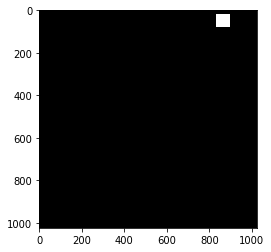

In [70]:
plt.imshow(Y, cmap='gray')

## Resizing

In [91]:
len(list(image_folder.iterdir()))

3423

In [93]:
[x for x in list(image_folder.iterdir()) if x.suffix != ".jpg"]

[PosixPath('../data/train/.ipynb_checkpoints')]

In [71]:
def resize_tr(im, bboxes, sz):
    """
    Resize image and bbox at the same time.
    """
    Ys = [make_bb_px(bb, im) for bb in bboxes]
    im2 = cv2.resize(im, (sz, sz))
    Y2s = [cv2.resize(Y, (sz, sz)) for Y in Ys]
    return im2, np.stack([to_bb(Y2) for Y2 in Y2s])

def resize_all_images(df, train_path, valid_path, org_path, sz=224):
    """
    Resize all images and store in folders.
    """
    tmp = df.copy()
    files = list(org_path.iterdir())  # if x.suffix == ".jpg"
    annos_id = df.image_id.values  # consider other images in the future
    
    for f in files:
        image_id = f.parts[-1]
        if image_id in annos_id:
            if image_id not in valid_id:
                new_path = train_path/image_id
            else:
                new_path = valid_path/image_id
            im, bboxes = get_im_bb(f, df)
            im, bboxes = resize_tr(im, bboxes, sz)

            cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR)) 
            tmp.loc[tmp.image_id == image_id, ["xmin", "ymin", "xmax", "ymax"]] = bboxes
    
    tmp.to_csv(path/"wheat_224.csv", index=False)

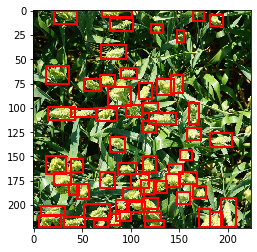

In [72]:
# example after resizing
im_r, bboxes_r = resize_tr(im, bboxes, 224)
show_corner_bb(im_r, bboxes_r)

In [73]:
# folder to store resized images
train_path = path/"train_224"
valid_path = path/"valid_224"

# train_path.mkdir(exist_ok=True)
# valid_path.mkdir(exist_ok=True)

In [24]:
# only run once
# resize_all_images(wheat, train_path, valid_path, image_folder, sz=224)

In [74]:
# read resized bboxes back
resize_wheat = pd.read_csv(path/"wheat_224.csv")
resize_wheat.head()

,image_id,xmin,ymin,xmax,ymax
0,b6ab77fd7.jpg,182.0,48.0,194.0,56.0
1,b6ab77fd7.jpg,49.0,120.0,77.0,132.0
2,b6ab77fd7.jpg,82.0,110.0,98.0,145.0
3,b6ab77fd7.jpg,182.0,21.0,206.0,44.0
4,b6ab77fd7.jpg,6.0,31.0,32.0,56.0


In [75]:
resize_wheat[["xmin", "ymin", "xmax", "ymax"]].min()

xmin    0.0
ymin    0.0
xmax    0.0
ymax    0.0
dtype: float64

### Debug

- Remove tiny bboxes (after resizing, some xs and ys are the same).

In [76]:
# fix bugs
print(resize_wheat.shape[0])
resize_wheat = resize_wheat.loc[(resize_wheat.xmin < resize_wheat.xmax) & (resize_wheat.ymin < resize_wheat.ymax)]
print(resize_wheat.shape[0])

147793
147646


In [77]:
# number of annotated images remain
print(wheat.image_id.nunique())
print(resize_wheat.image_id.nunique())

3373
3373


In [79]:
# consider limiting the minimum area
areas = ((resize_wheat.ymax - resize_wheat.ymin) * (resize_wheat.xmax - resize_wheat.xmin))
np.quantile(areas, 0.001)

18.0

In [80]:
# new example
"b6ab77fd7.jpg" in valid_id

True

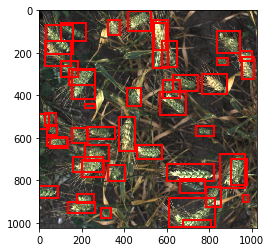

In [81]:
# before resizing
p = image_folder/"b6ab77fd7.jpg"
im, bboxes = get_im_bb(p, valid_wheat)
show_corner_bb(im, bboxes)

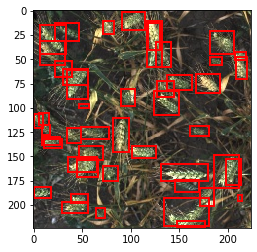

In [82]:
# after resizing
p_r = valid_path/"b6ab77fd7.jpg"
im_r, bboxes_r = get_im_bb(p_r, resize_wheat)
show_corner_bb(im_r, bboxes_r)

In [32]:
# write a test to check all images are resized

## Dataset

- **What if transforms result in empty bboxes?**
- **What about images without bounding boxes?**
- Reduce precision of decimals, float boxes don't work.
- How to clear GPU memory?
- Non-max suppression: how do you know it's the same object?
- kmeans of anchor boxes

In [151]:
class WheatDataSet(Dataset):
    def __init__(self, df, folder, transforms=None):
        self.df = df
        self.image_ids = [f.parts[-1] for f in list(folder.iterdir())]  # sample [:100]
        self.folder = folder
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # get image and boxes
        image_id = self.image_ids[idx]
        image, boxes = get_im_bb(self.folder/image_id, self.df)
        image = image.astype(np.float32) / 255.0  # normalize to 0~1
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # area of the bounding boxes
        
        # convert everything into tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        # compile target to return
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms:  # transform will turn bboxes into float type!
            # images augmentation
            augmented = {
                "image":image,
                "bboxes":boxes,
                "labels":labels,
            }
            augmented = self.transforms(**augmented)
            
            image = augmented["image"]  # tensor of (3, 224, 224)
            target["boxes"] = torch.tensor(augmented["bboxes"]).float()  # MUST have .float()
        
        return image, target, image_id[:-4]


In [152]:
# Albumentations
def get_train_transform():
    return A.Compose([
#         A.Flip(p=0.5),
#         A.ShiftScaleRotate(p=1),
        A.RandomSizedCrop((42-20, 42+20), 224, 224, p=1),
#         A.OneOf(
#             [
#                 A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1, val_shift_limit=0.1),
#                 A.RGBShift(r_shift_limit=0.1, g_shift_limit= 0.1, b_shift_limit=0.1)
#             ],
#             p=1
#         ),
#         A.OneOf(
#             [
#                 # apply one of transforms to 50% of images
#                 A.RandomContrast(), # apply random contrast
#                 A.RandomGamma(), # apply random gamma
#                 A.RandomBrightness(), # apply random brightness
#             ],
#             p=1
#         ),
        ToTensorV2(p=1.0)
    ], 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,  # 20, set as 0.1 percentile 
            min_visibility=0,
            label_fields=['labels']
        )
    )
    # bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )
    # bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}

In [148]:
train_ds = WheatDataSet(resize_wheat, train_path, get_train_transform())
valid_ds = WheatDataSet(resize_wheat, valid_path, get_valid_transform())

In [153]:
train_ds = WheatDataSet(resize_wheat, train_path)
valid_ds = WheatDataSet(resize_wheat, valid_path)

In [150]:
len(train_ds)

2741

In [36]:
train_ds[0]

(array([[[0.52156866, 0.5803922 , 0.46666667],
         [0.49803922, 0.5529412 , 0.4509804 ],
         [0.5686275 , 0.6039216 , 0.52156866],
         ...,
         [0.27058825, 0.31764707, 0.23921569],
         [0.13725491, 0.16470589, 0.10196079],
         [0.2627451 , 0.28627452, 0.23137255]],
 
        [[0.50980395, 0.5686275 , 0.45490196],
         [0.57254905, 0.62352943, 0.52156866],
         [0.49803922, 0.53333336, 0.4509804 ],
         ...,
         [0.3882353 , 0.43529412, 0.34117648],
         [0.3529412 , 0.3882353 , 0.3137255 ],
         [0.11764706, 0.14509805, 0.07450981]],
 
        [[0.5176471 , 0.5686275 , 0.4509804 ],
         [0.57254905, 0.62352943, 0.5137255 ],
         [0.5137255 , 0.5529412 , 0.45882353],
         ...,
         [0.24313726, 0.29411766, 0.18431373],
         [0.2627451 , 0.3019608 , 0.20392157],
         [0.19607843, 0.23529412, 0.13725491]],
 
        ...,
 
        [[0.02352941, 0.02745098, 0.00784314],
         [0.00784314, 0.01176471, 0.     

In [35]:
[ds for ds in train_ds[:10]]

TypeError: expected str, bytes or os.PathLike object, not list

In [344]:
for i in range(len(train_ds)):
    if train_ds[i][1]["boxes"].shape[0] == 0:
        print(i)

43
58
70
323
338
391
418
447
533
574
609
635
642
732
753
757
775
787
829


KeyboardInterrupt: 

In [341]:
[ds[1]["boxes"].shape for ds in train_ds]

KeyboardInterrupt: 

### Bug

- Tiny bboxes result in equal min max values.
- Remove these records in the resizing phase.

In [234]:
# resize_wheat.loc[resize_wheat.ymin >= resize_wheat.ymax]

In [235]:
# wheat.loc[wheat.image_id == "8b558e9e3.jpg"]
# show_corner_bb(*get_im_bb(image_folder/"8b558e9e3.jpg", wheat))

In [154]:
image, target, image_id = train_ds[21]  # "77d1f3c18.jpg"
image.shape, target["boxes"][:5]

((224, 224, 3),
 tensor([[103., 181., 143., 201.],
         [ 94., 123., 114., 151.],
         [ 47.,  63.,  68.,  91.],
         [116.,  20., 135.,  48.],
         [213.,  81., 223., 108.]]))

In [54]:
# resize_wheat.loc[resize_wheat.image_id == "77d1f3c18.jpg"][:5]

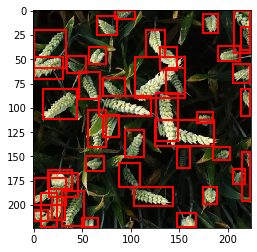

In [155]:
show_corner_bb(image, target["boxes"])  #.permute(1, 2, 0)

**Note**:
After transforms:
- _image_ from np.array to torch.tensor
- _image_ from (224, 224, 3) to (3, 224, 224)

### Expts on transforms

In [156]:
samp = {'image': image, 'bboxes': target['boxes'], 'labels': target["labels"]}
print(samp["bboxes"].shape)
print(samp["labels"].shape)

torch.Size([43, 4])
torch.Size([43])


In [158]:
samp_ = get_train_transform()(**samp)
print(len(samp_["bboxes"]))
print(len(samp_["labels"]))

0
0


In [160]:
samp_

{'image': tensor([[[0.1176, 0.1176, 0.1176,  ..., 0.0196, 0.0196, 0.0196],
          [0.1176, 0.1176, 0.1176,  ..., 0.0196, 0.0196, 0.0196],
          [0.1176, 0.1176, 0.1176,  ..., 0.0196, 0.0196, 0.0196],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0353, 0.0353, 0.0353],
          [0.0118, 0.0118, 0.0118,  ..., 0.0353, 0.0353, 0.0353],
          [0.0118, 0.0118, 0.0118,  ..., 0.0353, 0.0353, 0.0353]],
 
         [[0.1569, 0.1569, 0.1569,  ..., 0.0235, 0.0235, 0.0235],
          [0.1569, 0.1569, 0.1569,  ..., 0.0235, 0.0235, 0.0235],
          [0.1569, 0.1569, 0.1569,  ..., 0.0235, 0.0235, 0.0235],
          ...,
          [0.0196, 0.0196, 0.0196,  ..., 0.0471, 0.0471, 0.0471],
          [0.0196, 0.0196, 0.0196,  ..., 0.0471, 0.0471, 0.0471],
          [0.0196, 0.0196, 0.0196,  ..., 0.0471, 0.0471, 0.0471]],
 
         [[0.1137, 0.1137, 0.1137,  ..., 0.0039, 0.0039, 0.0039],
          [0.1137, 0.1137, 0.1137,  ..., 0.0039, 0.0039, 0.0039],
          [0.1137, 0.1137, 0.11

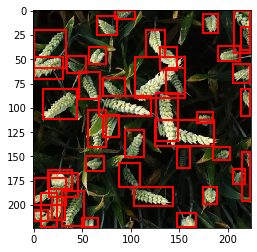

In [139]:
# before transform
show_corner_bb(samp["image"], samp["bboxes"])

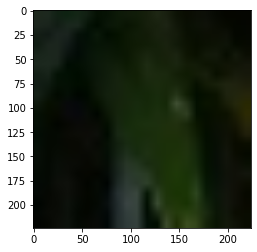

In [159]:
# after transform
show_corner_bb(samp_["image"].permute(1, 2, 0).numpy(), samp_["bboxes"])

In [323]:
# np.array(samp_["bboxes"])

array([[  0.        , 192.78686905,  23.86885238, 220.32787323],
       [163.40984154, 212.98360634, 205.63933945, 224.        ],
       [ 75.27868557, 181.77048874, 130.36066055, 214.81966972],
       [123.01639366, 167.08196831, 159.73770142, 198.29508591],
       [ 93.63934612, 167.08196831, 123.01639366, 183.60655212],
       [ 95.47540951, 134.03278732, 135.86885071, 163.40984154],
       [ 34.88524437, 134.03278732,  71.60654545, 163.40984154],
       [ 73.44262218,  71.6065588 , 113.83606339, 108.32786655],
       [ 38.55737782,  66.09836197,  64.26229191,  93.63934612],
       [  0.        ,  64.26229191,  20.1967206 ,  89.96721268],
       [123.01639366,  66.09836197, 154.22951126, 110.16393661],
       [179.93442535,  89.96721268, 200.13114929, 123.01639366],
       [194.62294579,  88.13114929, 212.98360634, 110.16393661],
       [198.29508591, 115.67212677, 222.16393661, 156.06557465],
       [176.26229858, 137.70491409, 209.31147957, 165.24590492],
       [159.73770142, 148

## Load model

In [243]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [244]:
# reference: https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
# define loss metric
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
    
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0: 
            return 0
        else:
            return self.current_total / self.iterations  # 1.0 *
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [245]:
# customize batch?
def collate_fn(batch):
#     images, targets = tuple(zip(*batch))
#     images = torch.stack(images)
#     return images, targets
    return tuple(zip(*batch))  # pack image & target into a tuple

In [246]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [247]:
# train_dl = DataLoader(train_ds, batch_size=2, collate_fn=collate_fn, shuffle=True, num_workers=4)  
# valid_dl = DataLoader(valid_ds, batch_size=2, collate_fn=collate_fn, num_workers=4)

In [248]:
# # example
# images, targets = next(iter(train_dl))

# # cuda for training
# images = list(image.cuda() for image in images)
# targets = [{k:v.cuda() for k, v in t.items()} for t in targets]

In [249]:
# images[0].shape

In [250]:
# images[0], targets[0]

In [251]:
# # example after augmentation
# bboxes_a = targets[0]["boxes"].cpu().detach().numpy()  #.astype(np.int32)
# im_a = images[0].permute(1, 2, 0).cpu().detach().numpy()  #.astype(np.int32)

# show_corner_bb(im_a, bboxes_a)

In [252]:
# model.cuda()

In [253]:
# model(images, targets)

In [254]:
# from pynvml import *
# nvmlInit()
# h = nvmlDeviceGetHandleByIndex(0)
# info = nvmlDeviceGetMemoryInfo(h)
# print(f'total    : {info.total}')
# print(f'free     : {info.free}')
# print(f'used     : {info.used}')

### Train model

In [255]:
def train_epocs(model, optimizer, train_dl, valid_dl, epochs=10):
    loss_hist = Averager()
    itr = 0
    for i in range(epochs):
        model.train()
        loss_hist.reset()
        for images, targets, image_ids in train_dl:
            images = list(image.cuda() for image in images)
            targets = [{k:v.cuda() for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            loss_hist.send(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            itr += 1
            if itr % 50 == 0:
                print(f"Iteration {itr} loss: {loss_hist.value:.3f}")

#         val_loss = val_metrics(model, valid_dl)
        print("train loss %.3f" % (loss_hist.value))
#         print("train loss %.3f val loss %.3f" % (loss_hist.value, val_loss))   

In [256]:
# def val_metrics(model, valid_dl):
#     model.eval()
#     loss_hist = Averager()
#     for images, targets, image_ids in valid_dl:
#         images = list(image.cuda() for image in images)
#         targets = [{k:v.cuda() for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()
#         loss_hist.send(loss_value)

#     return loss_hist.value

In [257]:
model.cuda()

# parameters = filter(lambda p: p.requires_grad, model.parameters())
# optimizer = torch.optim.Adam(parameters, lr=0.001, weight_decay=0.0005)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [258]:
batch_size = 8
train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=4)  
valid_dl = DataLoader(valid_ds, batch_size=batch_size, collate_fn=collate_fn, num_workers=4)

In [259]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=2)

Iteration 50 loss: 1.366
Iteration 100 loss: 1.214
Iteration 150 loss: 1.146
Iteration 200 loss: 1.109
Iteration 250 loss: 1.075
Iteration 300 loss: 1.056
train loss 1.041
Iteration 350 loss: 0.885
Iteration 400 loss: 0.932
Iteration 450 loss: 0.920
Iteration 500 loss: 0.917
Iteration 550 loss: 0.915
Iteration 600 loss: 0.913
Iteration 650 loss: 0.908
train loss 0.908


In [97]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 11996954624
free     : 982843392
used     : 11014111232


## Prediction

In [98]:
images, targets, image_ids = next(iter(valid_dl))

images = list(image.cuda() for image in images)
targets = [{k:v.cuda() for k, v in t.items()} for t in targets]

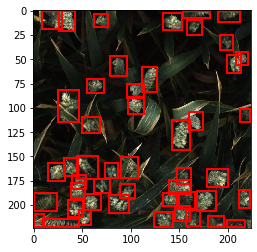

In [99]:
# original
i = 
bboxes = targets[i]["boxes"].cpu().detach().numpy()  #.astype(np.int32)
im = images[i].permute(1, 2, 0).cpu().detach().numpy()  #.astype(np.int32)

show_corner_bb(im, bboxes)

In [70]:
len(images)

8

In [71]:
images[0].shape

torch.Size([3, 224, 224])

In [75]:
# model.eval()
# outputs = model(images, targets)

In [100]:
model.eval()
outputs = model(images)
outputs = [{k:v.cpu() for k, v in t.items()} for t in outputs]

In [73]:
outputs

[{'boxes': tensor([[5.4604e+01, 7.1623e+01, 7.6682e+01, 8.9193e+01],
          [1.2218e+02, 2.0434e-01, 1.4699e+02, 1.2454e+01],
          [2.0314e+01, 4.8981e+01, 3.8772e+01, 6.9632e+01],
          [1.3277e+02, 1.1422e+02, 1.5070e+02, 1.3319e+02],
          [2.0706e+01, 1.1426e+02, 5.0934e+01, 1.3097e+02],
          [2.0304e+02, 1.8651e+02, 2.2084e+02, 2.0559e+02],
          [4.8744e+01, 5.7956e+01, 7.2416e+01, 7.3079e+01],
          [1.0781e+02, 1.1449e+02, 1.2924e+02, 1.2873e+02],
          [1.4736e+02, 1.6795e+02, 1.7483e+02, 1.8984e+02],
          [9.4034e+01, 1.5910e+02, 1.1795e+02, 1.8377e+02],
          [5.7524e+01, 9.1845e+01, 7.5836e+01, 1.0554e+02],
          [5.6861e+01, 1.6782e+02, 7.6899e+01, 1.8829e+02],
          [1.7658e+02, 1.1305e+02, 1.9446e+02, 1.3277e+02],
          [1.9768e+02, 6.9215e+01, 2.2159e+02, 9.2021e+01],
          [1.9957e+02, 5.1340e+01, 2.1540e+02, 6.6911e+01],
          [1.6819e+02, 6.8370e+01, 1.8539e+02, 8.5171e+01],
          [1.8296e+02, 1.7874e+

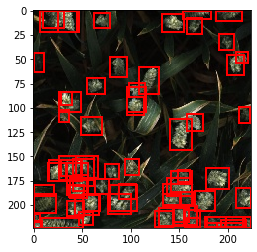

In [101]:
# predicted
i = 3
bboxes_p = outputs[i]["boxes"].detach().numpy()  #.astype(np.int32)
im = images[i].permute(1, 2, 0).cpu().detach().numpy()  #.astype(np.int32)

show_corner_bb(im, bboxes_p)

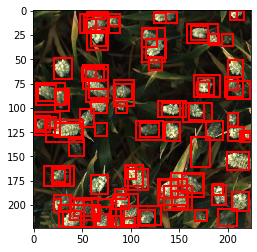

In [80]:
# predicted
bboxes_p = outputs[0]["boxes"].detach().numpy()  #.astype(np.int32)
im = images[0].permute(1, 2, 0).cpu().detach().numpy()  #.astype(np.int32)

show_corner_bb(im, bboxes_p)

In [73]:
del model

In [83]:
torch.cuda.empty_cache()

In [63]:
torch.cuda.get_device_properties(0).total_memory

11996954624

In [1]:
torch.cuda.memory_cached(0)

NameError: name 'torch' is not defined

In [65]:
torch.cuda.memory_allocated(0)

687244288